In [1]:
import pandas as pd
import os
import re
import spacy
from gensim.models.phrases import Phrases, Phraser

In [2]:
import multiprocessing
from gensim.models import Word2Vec
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import scale
import keras 
from keras.models import Sequential, Model 
from keras import layers
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Input, Embedding
from keras.layers.merge import Concatenate
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1) or '1type' as

In [3]:
import multiprocessing
from gensim.models import Word2Vec
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import scale
import keras 
from keras.models import Sequential, Model 
from keras import layers
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Input, Embedding
from keras.layers.merge import Concatenate
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import confusion_matrix

In [3]:
data = pd.read_csv("Uber_Category_3000.csv",encoding='latin1')

In [4]:
data.head()

,Tweets,Category
0,hi we understand this can be upsetting driver ...,1
1,hey savani weve fixed this for you and process...,1
2,hey sanju for us to assist you better kindly h...,1
3,we understand your concern nikhil we have made...,0
4,hey vinay were sorry to hear about the trouble...,1


In [5]:
df_clean = data
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
df_clean['clean'] = df_clean['Tweets'].astype('str') 
df_clean.dtypes

df_clean["tokens"] = df_clean["clean"].apply(tokenizer.tokenize)

In [6]:
df_clean.head()

,Tweets,Category,clean,tokens
0,hi we understand this can be upsetting driver ...,1,hi we understand this can be upsetting driver ...,"[hi, we, understand, this, can, be, upsetting,..."
1,hey savani weve fixed this for you and process...,1,hey savani weve fixed this for you and process...,"[hey, savani, weve, fixed, this, for, you, and..."
2,hey sanju for us to assist you better kindly h...,1,hey sanju for us to assist you better kindly h...,"[hey, sanju, for, us, to, assist, you, better,..."
3,we understand your concern nikhil we have made...,0,we understand your concern nikhil we have made...,"[we, understand, your, concern, nikhil, we, ha..."
4,hey vinay were sorry to hear about the trouble...,1,hey vinay were sorry to hear about the trouble...,"[hey, vinay, were, sorry, to, hear, about, the..."


In [7]:
import gensim
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)


In [8]:
# WORD2VEC()
cores = multiprocessing.cpu_count() # Count the number of cores in a computer, important for a parameter of the model
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

#BUILD_VOCAB()

w2v_model.build_vocab(df_clean["tokens"], progress_per=1000)


#TRAIN()

w2v_model.train(df_clean["tokens"], total_examples=w2v_model.corpus_count, epochs=10000, report_delay=1)


(107049504, 941840000)

In [14]:
#words similar to thanks
w2v_model.wv.most_similar(positive=["thanks"])

#Words similar to please
w2v_model.wv.most_similar(positive=["please"])

[('via', 0.3997763395309448),
 ('help', 0.38794752955436707),
 ('section', 0.3862268626689911),
 ('app', 0.3510473966598511),
 ('message', 0.3264971971511841),
 ('your', 0.31966665387153625),
 ('direct', 0.30337798595428467),
 ('us', 0.2930665910243988),
 ('number', 0.2755545973777771),
 ('email', 0.2735200524330139)]

In [15]:
# defining the chart
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="A map of 10000 word vectors",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

# getting a list of word vectors. limit to 10000. each is of 200 dimensions
word_vectors = [w2v_model[w] for w in list(w2v_model.wv.vocab.keys())[:5000]]

# dimensionality reduction. converting the vectors to 2d vectors
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(word_vectors)

# putting everything in a dataframe
tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df['words'] = list(w2v_model.wv.vocab.keys())[:5000]

# plotting. the corresponding word appears when you hover on the data point.
plot_tfidf.scatter(x='x', y='y', source=tsne_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"word": "@words"}
show(plot_tfidf)

Loading BokehJS ...

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 298 samples in 0.064s...
[t-SNE] Computed neighbors for 298 samples in 0.115s...
[t-SNE] Computed conditional probabilities for sample 298 / 298
[t-SNE] Mean sigma: 5.909449
[t-SNE] KL divergence after 250 iterations with early exaggeration: 105.757591
[t-SNE] KL divergence after 1000 iterations: 1.274448


In [9]:
#First defining the X (input), and the y (output)

y = data['Category'].values
X = np.array(df_clean["tokens"])

#And here is the train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [10]:
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform([x for x in X_train])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print ('vocab size :', len(tfidf))

vocab size : 391


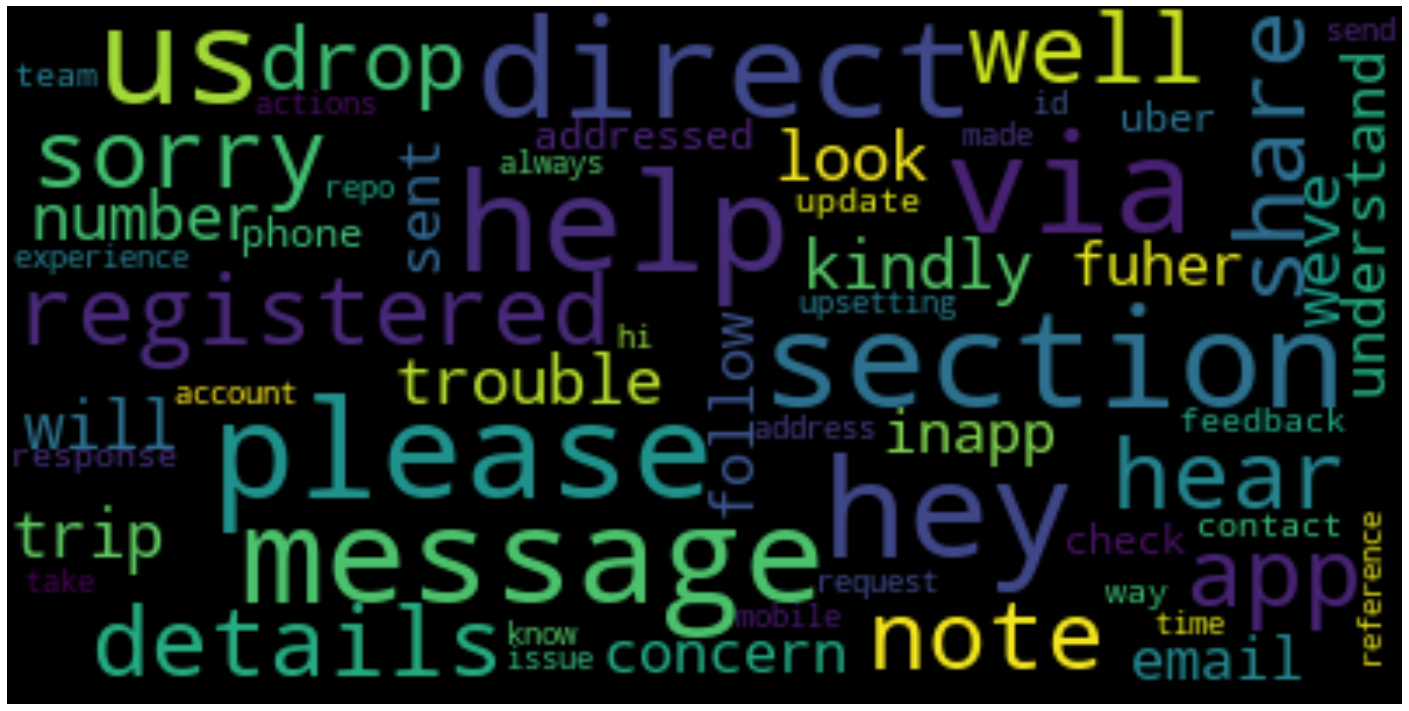

In [19]:
import matplotlib.pyplot as plt

def plot_word_cloud(terms):
    text = terms.index
    text = ' '.join(list(text))
    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure(figsize=(25, 25))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
tfidf2 = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf2.columns = ['tfidf']
plot_word_cloud(tfidf2.sort_values(by=['tfidf'], ascending=True).head(100))

In [11]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += w2v_model[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [12]:
train_vecs_w2v = np.concatenate([buildWordVector(z, 300) for z in map(lambda x: x, X_train)])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, 300) for z in map(lambda x: x, X_test)])
test_vecs_w2v = scale(test_vecs_w2v)

print ('shape for training set : ',train_vecs_w2v.shape,
      '\nshape for test set : ', test_vecs_w2v.shape)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


shape for training set :  (2399, 300) 
shape for test set :  (600, 300)


In [19]:
model = Sequential()

model.add(Dense(128,activation='relu', input_dim=300))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               38528     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 55,169
Trainable params: 55,169
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(train_vecs_w2v, y_train, epochs=20, batch_size=50,
                   validation_data=(test_vecs_w2v,y_test))
loss, accuracy = model.evaluate(train_vecs_w2v, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(test_vecs_w2v, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 2399 samples, validate on 600 samples
Epoch 1/20
2399/2399 [==============================] - 1s 389us/step - loss: 0.4542 - accuracy: 0.8099 - val_loss: 0.3171 - val_accuracy: 0.8617
Epoch 2/20
2399/2399 [==============================] - 0s 86us/step - loss: 0.3678 - accuracy: 0.8495 - val_loss: 0.2765 - val_accuracy: 0.8800
Epoch 3/20
2399/2399 [==============================] - 0s 84us/step - loss: 0.3067 - accuracy: 0.8791 - val_loss: 0.2484 - val_accuracy: 0.9100
Epoch 4/20
2399/2399 [==============================] - 0s 77us/step - loss: 0.2681 - accuracy: 0.8875 - val_loss: 0.2336 - val_accuracy: 0.9150
Epoch 5/20
2399/2399 [==============================] - 0s 88us/step - loss: 0.2591 - accuracy: 0.8929 - val_loss: 0.2178 - val_accuracy: 0.9383
Epoch 6/20
2399/2399 [==============================] - 0s 83us/step - loss: 0.2376 - accuracy: 0.9083 - val_loss: 0.2216 - val_accuracy: 0.9183
Epoch 7/20
2399/2399 [==============================] - 0s 86us/step - loss: 0.220

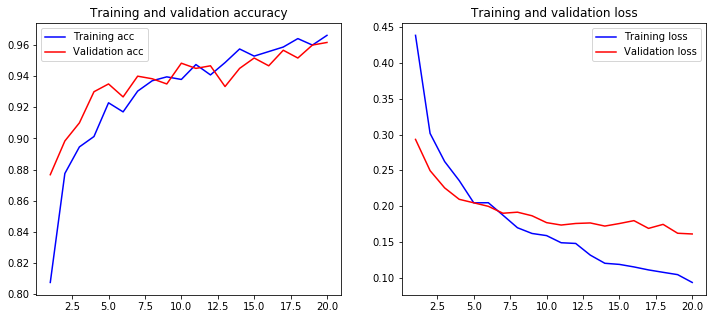

In [18]:
import matplotlib.pyplot as plt
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)

In [21]:
all_words = [word for tokens in X for word in tokens]
all_sentence_lengths = [len(tokens) for tokens in X]
ALL_VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(ALL_VOCAB)))
print("Max sentence length is %s" % max(all_sentence_lengths))


94184 words total, with a vocabulary size of 2189
Max sentence length is 55


In [22]:
####################### CHANGE THE PARAMETERS HERE #####################################
EMBEDDING_DIM = 300 # how big is each word vector
MAX_VOCAB_SIZE = 2189 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH = 55 # max number of words in a comment to use

In [23]:

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(data["Tweets"].tolist())
training_sequences = tokenizer.texts_to_sequences(X_train.tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = w2v_model[word] if word in w2v_model else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

Found 2199 unique tokens.
(2200, 300)


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if sys.path[0] == '':
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [24]:
######################## TRAIN AND TEST SET #################################
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_sequences = tokenizer.texts_to_sequences(X_test.tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [25]:
from keras.layers import concatenate
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, trainable=False, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = concatenate([convs[0],convs[1],convs[2]],axis=1)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    # Finally, we feed the output into a Sigmoid layer.
    # The reason why sigmoid is used is because we are trying to achieve a binary classification(1,0) 
    # for each of the 6 labels, and the sigmoid function will squash the output between the bounds of 0 and 1.
    preds = Dense(1,activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])
    model.summary()
    return model

In [26]:
model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, False)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 55)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 55, 300)      660000      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 53, 128)      115328      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 52, 128)      153728      embedding_1[0][0]                
____________________________________________________________________________________________

In [27]:
history = model.fit(train_cnn_data, y_train, epochs=10, batch_size=50,
                   validation_data=(test_cnn_data,y_test))
loss, accuracy = model.evaluate(train_cnn_data, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(test_cnn_data, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 2399 samples, validate on 600 samples
Epoch 1/10
2399/2399 [==============================] - 8s 3ms/step - loss: 0.4480 - accuracy: 0.8437 - val_loss: 0.3143 - val_accuracy: 0.9017
Epoch 2/10
2399/2399 [==============================] - 7s 3ms/step - loss: 0.2432 - accuracy: 0.9041 - val_loss: 0.2387 - val_accuracy: 0.9200
Epoch 3/10
2399/2399 [==============================] - 7s 3ms/step - loss: 0.1377 - accuracy: 0.9500 - val_loss: 0.1625 - val_accuracy: 0.9417
Epoch 4/10
2399/2399 [==============================] - 7s 3ms/step - loss: 0.0861 - accuracy: 0.9708 - val_loss: 0.1572 - val_accuracy: 0.9517
Epoch 5/10
2399/2399 [==============================] - 7s 3ms/step - loss: 0.0591 - accuracy: 0.9796 - val_loss: 0.1967 - val_accuracy: 0.9467
Epoch 6/10
2399/2399 [==============================] - 7s 3ms/step - loss: 0.0418 - accuracy: 0.9879 - val_loss: 0.2578 - val_accuracy: 0.9533
Epoch 7/10
2399/2399 [==============================] - 7s 3ms/step - loss: 0.0475 - accu

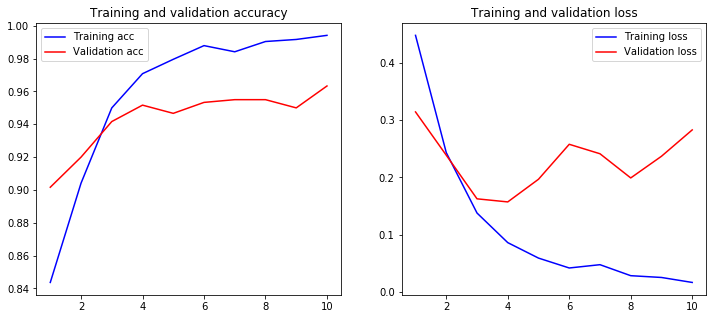

In [28]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)